# Can we predict the Midterm Elections?

---


## Introduction

I will use the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api/v2) to extract the polls for the current 2014 Senate Midterm Elections and provide a final prediction of the result of each state.

#### Data

We will use the polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api/v2). 

---

## Problem 1: Data Wrangling

We will read in the polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api/v2) and create a dictionary of DataFrames as well a master table information for each race.

#### Problem 1(a)

Read in [this JSON object](http://elections.huffingtonpost.com/pollster/api/v2/charts/?topic=2014-senate) containing the polls for the 2014 Senate Elections using the HuffPost API. Call this JSON object `info`.

In [1]:
%matplotlib inline

import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from bs4 import BeautifulSoup
from collections import defaultdict

In [2]:
info = requests.get('http://elections.huffingtonpost.com/pollster/api/v2/charts/',
                    params={'tags': '2014-senate'}).json()
type(info)

dict

#### Problem 1(b)

For each element in `info` we extract the state. We should have one poll per state, but we do not. Why?

In [3]:
new_info = defaultdict(list)
for i in info['items']:
    state = i['question']['slug'].split('-')[1]
    candidates = set([c['label'] for c in i['question']['responses']])
    candidates.discard('Undecided')
    candidates.discard('Other')
    if (state not in new_info
        or not set([c['label'] for s in new_info[state] for c in s['question']['responses']]) & candidates):
        # Append a race if its state is not in our dictionary
        # or if this race is a special election ie. no overlap between candidate lists
        new_info[state].append(i)
    else:
        for idx, v in enumerate(new_info[state]):
            if (set([c['label'] for c in v['question']['responses']]) & candidates
                and i['question']['n_polls'] > v['question']['n_polls']):
                # Replace a current race with one that has larger n_polls
                # if there's an overlap between candidate lists
                new_info[state][idx] = i
unpacked_new_info = [rc for v in new_info.values() for rc in v]

There are polls for races that have never happened, and there are special elections at some states.

#### Problem 1(c)

We create a dictionary of pandas DataFrames called `polls` keyed by the name of the election (a string). Each value in the dictionary should contain the polls for one of the races.

In [4]:
polls = {}
for rc in unpacked_new_info:
    polls[rc['slug']] = pd.read_csv('http://elections.huffingtonpost.com/pollster/api/v2/questions/'
                                    + rc['question']['slug'] + '/poll-responses-clean.tsv', sep='\t')

#### Problem 1(d)

Now we create a master table information containing information about each race. We create a pandas DataFrame called `candidates` with rows containing information about each race. The `candidates` DataFrame should have the following columns: 

1. `State` = the state where the race is being held
2. `R` = name of republican candidate
3. `D` = name of non-republican candidate (Democrate or Independent) 
4. `incumbent` = R, D or NA

We will need a considerable amount of data wrangling for this.

In [5]:
candidates = defaultdict(list)
for rc in (rc['question'] for v in new_info.values() for rc in v):
    candidates['State'].append(rc['slug'].split('-')[1])
    for rspns in rc['responses']:
        if rspns['party'] == 'Republican':
            candidates['R'].append(rspns['label'])
            if rspns['incumbent']:
                candidates['incumbent'].append('R')
        if rspns['party'] == 'Democrat':
            candidates['D'].append(rspns['label'])
            if rspns['incumbent']:
                candidates['incumbent'].append('D')
    if len(candidates['incumbent']) < len(candidates['State']):
        # Set incumbent = 'NA' if there are no incumbents in the race
        candidates['incumbent'].append('NA')
candidates = pd.DataFrame(candidates)
candidates.head()

,D,R,State,incumbent
0,Franken,McFadden,MN,D
1,Grimes,Bevin,KY,NA
2,Shaheen,Brown,NH,D
3,Johnson,Lankford,OK,NA
4,Silverstein,Inhofe,OK,R


## Problem 2: Confidence Intervals

Compute a 99% confidence interval for each state. 

#### Problem 2(a)

Assume we have $M$ polls with sample sizes $n_1, \dots, n_M$. If the polls are independent, the average of the variances of each poll if the true proportion is $p$ is:$$ \frac{p(1-p)(1/n_1 + \dots +1/n_M)}{M} $$

#### Problem 2(b)

We compute the square root of these values in Problem 2(a) for the republican candidates in each race. Then, we compute the standard deviations of the observed poll results for each race. 

In [6]:
average_std = {}
poll_std = {}
results = BeautifulSoup(requests.get('http://elections.huffingtonpost.com/2014/results').text, 'lxml')
for rc in unpacked_new_info:
    candidates = set([c['label'].strip() for c in rc['question']['responses']])
    p = 0
    slug = rc['slug']
    for r in results.find_all('div', attrs={'class': 'race closed',
                                            'data-state': rc['question']['slug'].split('-')[1]}):
        if set([c.contents[0].strip() for c in r.find_all('span', class_='nowrap')]) & candidates:
            # Look for the table that contains the result for our candidates
            for prf in r.find_all('tr'):
                if prf.find('td', class_='party').span['class'][0] == 'gop':
                    # Extract the result if the Party is Republican
                    p = float(prf.find('td', class_='pct').text.strip('%')) / 100
                    break
            break
    # Calculate the theoretical standard deviation of the winning proportion
    average_std[rc['slug']] = ((p * (1-p))  **  (1/2)   *   (1  /  polls[rc['slug']].observations ** (1/2)).sum()
                               / len(polls[rc['slug']]))
    for r in rc['question']['responses']:
        if r['party'] == 'Republican':
            # Calculate the sample standard deviation of the winning proportion
            poll_std[slug] = (polls[slug][r['label']] / 100.).std()
            break
average_std

{'2014-alaska-senate-sullivan-vs-begich': 0.019892165675659674,
 '2014-colorado-senate-gardner-vs-udall': 0.017924720053945988,
 '2014-delaware-senate-wade-vs-coons': 0.020061905992706238,
 '2014-georgia-senate-perdue-vs-nunn': 0.01703528258170914,
 '2014-hawaii-senate-cavasso-vs-schatz': 0.014841748908083423,
 '2014-idaho-senate-risch-vs-mitchell': 0.018699674757838795,
 '2014-illinois-senate-oberweis-vs-durbin': 0.014974966532593148,
 '2014-iowa-senate-ernst-vs-braley': 0.016964242874140376,
 '2014-kansas-senate-roberts-vs-orman-vs-taylor': 0.017402384891057072,
 '2014-kentucky-senate-bevin-vs-grimes': 0.015991792139403625,
 '2014-maine-senate-collins-vs-bellows': 0.01749709212412391,
 '2014-massachusetts-senate-herr-vs-markey': 0.019155918993806236,
 '2014-minnesota-senate-mcfadden-vs-franken': 0.01677400671153924,
 '2014-mississippi-senate-cochran-vs-childers': 0.018129204754492177,
 '2014-montana-senate-daines-vs-walsh': 0.01871621341057438,
 '2014-nebraska-senate-sasse-vs-domina'

#### Problem 2(c) 

Plot observed versus theoretical (average of the theoretical SDs) with the area of the point proportional to number of polls.

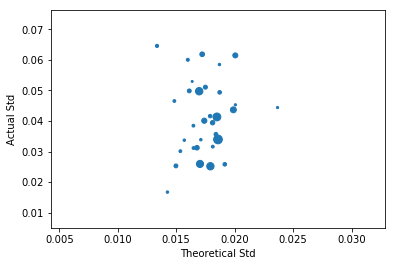

In [7]:
races = sorted(list(average_std))
plt.scatter([average_std[rc] for rc in races], [poll_std[rc] for rc in races], s=[len(polls[rc]) for rc in races])
plt.xlabel('Theoretical Std')
plt.ylabel('Actual Std')
plt.show()

The theoretical and actual std do not match and the actual std tends to be higher. This might be due to the non-stationary data ie. the voting opinion had changed over time.

#### Problem 2(d)

We repeat Problem 2(c) but include only the most recent polls from the last two months.

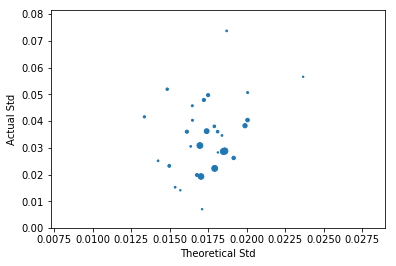

In [8]:
recent_poll_std = {}
for rc in unpacked_new_info:
    slug = rc['slug']
    for r in rc['question']['responses']:
        if r['party'] == 'Republican':
            # Calculate the std for polls from the last two months if the Party is Republican
            recent_poll_std[slug] = (polls[slug][pd.to_datetime(polls[slug].end_date)
                                                 > pd.datetime(2014, 9, 3)][r['label']] / 100).std()
            break

plt.scatter([average_std[rc] for rc in races], [recent_poll_std[rc] for rc in races],
            # Increase the dot size of those races with a larger number of polls
            s=[len(polls[rc][pd.to_datetime(polls[rc].end_date) > pd.datetime(2014, 9, 3)]) for rc in races])
plt.xlabel('Theoretical Std')
plt.ylabel('Actual Std')
plt.show()

They match better but not significantly. It seems that the theoretical std broke down due to the difference in the true proportion p between pollsters.

#### Problem 2(e)

We create a scatter plot with each point representing one state.

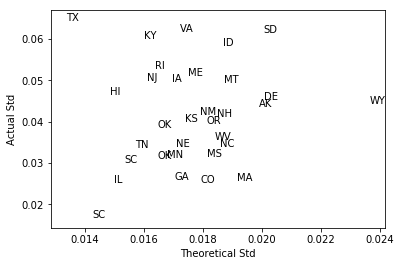

In [9]:
race_states = {rc['slug']: rc['question']['slug'].split('-')[1] for rc in unpacked_new_info}
plt.scatter([average_std[rc] for rc in races], [poll_std[rc] for rc in races], s=0)
plt.xlabel('Theoretical Std')
plt.ylabel('Actual Std')
for idx, v in enumerate([average_std[rc] for rc in races]):
    plt.text(v, [poll_std[rc] for rc in races][idx], [race_states[rc] for rc in races][idx])

** My answer here: ** There are states like Texas that has much larger variabilities than expected.

#### Problem 2(f)

We construct confidence intervals for the difference in each race. We use theoretical estimates of the standard error depending on our answer to this question.

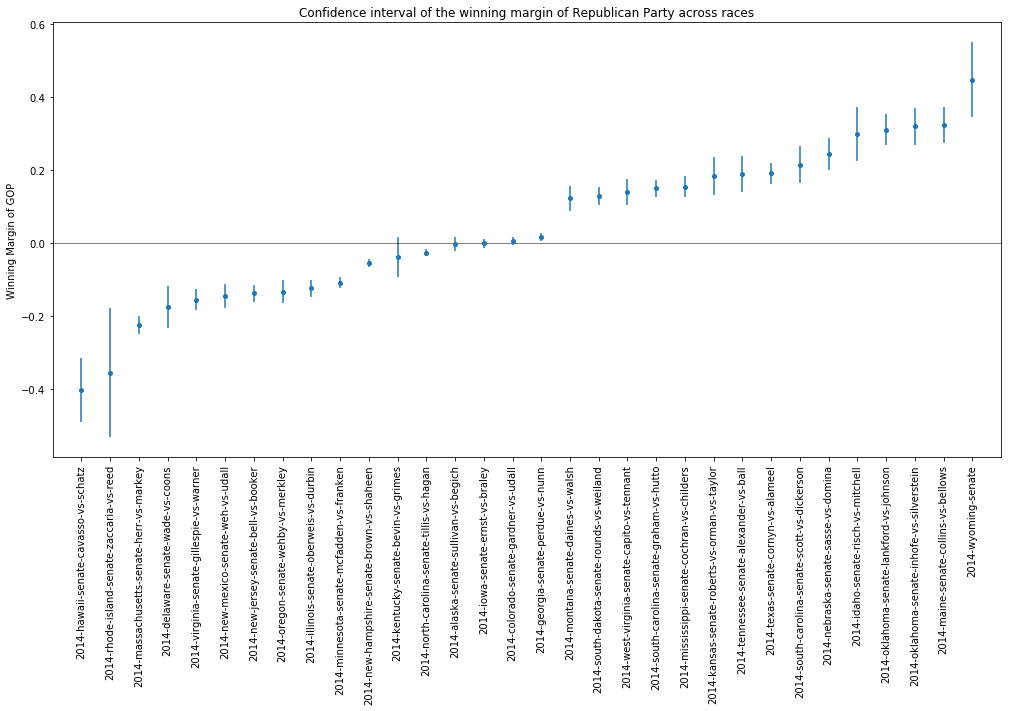

In [10]:
# Extract race stats to a dict
confidence = defaultdict(list)
for rc in unpacked_new_info:
    slug = rc['slug']
    confidence['race'].append(slug)
    for r in rc['question']['responses']:
        if r['party'] == 'Republican':
            gop = r['label']
        elif r['party'] == 'Democrat':
            dem = r['label']
    confidence['diff_mean'].append((polls[slug][gop]-polls[slug][dem]).mean() / 100)
    confidence['diff_std'].append(((polls[slug][gop]-polls[slug][dem]) / 100).std())
    confidence['n_polls'].append(len(polls[slug]))

# Convert dict to df and calculate the confidence interval
confidence = pd.DataFrame(confidence)
confidence['ste'] = confidence.diff_std  /  confidence.n_polls ** (1/2)
confidence['lower_bound'] = (confidence.diff_mean + confidence.ste*stats.t.interval(.95, confidence.n_polls - 1)[0])
confidence['upper_bound'] = (confidence.diff_mean + confidence.ste*stats.t.interval(.95, confidence.n_polls - 1)[1])
confidence.sort_values('diff_mean', inplace=True)
confidence.reset_index(inplace=True)

plt.figure(figsize=(17, 8))
plt.xticks(confidence.index, confidence.race, rotation=90)
plt.xlim(-1, confidence.shape[0])
plt.errorbar(confidence.index, confidence.diff_mean, fmt='o', ms=4,
             yerr = confidence.ste * stats.t.interval(.95, confidence.n_polls - 1)[1])
plt.axhline(0, linewidth=.5, color='black')
plt.ylabel('Winning Margin of GOP')
plt.title('Confidence interval of the winning margin of Republican Party across races')
plt.show()

# Problem 3: Prediction and Posterior Probabilities

We perform a Bayesian analysis to predict the probability of Republicans winning in each state then provide a posterior distribution of the number of republicans in the senate.

#### Problem 3(a)

First, we define a Bayesian model for each race. The prior for the difference $\theta$ between republicans and democrats will be $N(\mu,\tau^2)$. Say before seeing poll data we have no idea who is going to win, we assume $\mu$=0 be. $\tau$ should be small as the empirical variance of $\theta$ is not large and we also not want to set too extreme a prior.

#### Problem 3(b)

$d \mid \theta \sim N(\theta, \sigma^2/M)$.

$\theta \mid d \sim N\left(B\mu + (1-B)d, (1-B)\sigma^2/M\right)$, where $B = \frac{1/\tau^2}{M/\sigma^2 + 1/\tau^2}$.

#### Problem 3(c)

The prior represents what we think before hand. We do not know who is expected to win, so we assume $\mu=0$. For this problem estimate $\tau$ using the observed differences across states ($\tau$ represents the standard deviation of a typical difference). We compute the posterior mean for each state and plot it against original average.

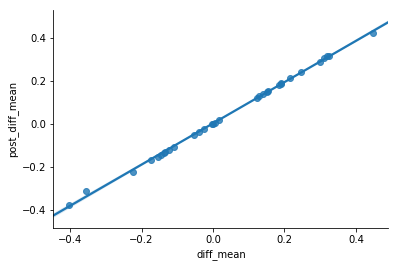

In [11]:
diffs = []
for rc in unpacked_new_info:
    slug = rc['slug']
    for r in rc['question']['responses']:
        if r['party'] == 'Republican':
            gop = r['label']
        elif r['party'] == 'Democrat':
            dem = r['label']
    diffs += list((polls[slug][gop]-polls[slug][dem]) / 100)
tau0 = np.nanstd(diffs)
# Calculate the posterior mean
confidence['post_diff_mean'] = (confidence.diff_mean * confidence.n_polls / confidence.diff_std**2
                                / (1 / tau0**2  +  confidence.n_polls / confidence.diff_std**2))
# Calculate the posterior std
confidence['post_diff_std'] = (1 / tau0**2  +  confidence.n_polls / confidence.diff_std**2) ** (-1/2)
sns.regplot(confidence.diff_mean, confidence.post_diff_mean)
sns.despine()
plt.show()

There is not much change. This means either we chose a reasonable prior distribution or n_polls for some states are too small.

#### Problem 3(d)

For each state, report a probabilty of Republicans winning.

In [12]:
confidence['gop_win_proba'] = stats.norm.sf(0, confidence.post_diff_mean, confidence.post_diff_std)
confidence

,index,diff_mean,diff_std,n_polls,race,ste,lower_bound,upper_bound,post_diff_mean,post_diff_std,gop_win_proba
0,23,-0.403750,0.104872,8,2014-hawaii-senate-cavasso-vs-schatz,0.037078,-0.491425,-0.316075,-0.380380,0.035989,2.066437e-26
1,27,-0.355000,0.111505,4,2014-rhode-island-senate-zaccaria-vs-reed,0.055752,-0.532429,-0.177571,-0.311701,0.052242,1.212013e-09
2,15,-0.224615,0.041756,13,2014-massachusetts-senate-herr-vs-markey,0.011581,-0.249848,-0.199382,-0.223277,0.011547,1.308960e-83
3,10,-0.174000,0.046152,5,2014-delaware-senate-wade-vs-coons,0.020640,-0.231305,-0.116695,-0.170749,0.020446,3.378450e-17
4,6,-0.154545,0.066456,22,2014-virginia-senate-gillespie-vs-warner,0.014169,-0.184011,-0.125080,-0.153171,0.014105,9.031843e-28
5,12,-0.145833,0.051603,12,2014-new-mexico-senate-weh-vs-udall,0.014897,-0.178620,-0.113046,-0.144401,0.014823,1.002187e-22
6,30,-0.137333,0.041998,15,2014-new-jersey-senate-bell-vs-booker,0.010844,-0.160591,-0.114076,-0.136615,0.010815,7.070639e-37
7,24,-0.133158,0.066085,19,2014-oregon-senate-wehby-vs-merkley,0.015161,-0.165010,-0.101306,-0.131804,0.015084,1.184604e-18
8,5,-0.124000,0.041023,15,2014-illinois-senate-oberweis-vs-durbin,0.010592,-0.146718,-0.101282,-0.123381,0.010566,8.285021e-32
9,0,-0.108095,0.035584,21,2014-minnesota-senate-mcfadden-vs-franken,0.007765,-0.124293,-0.091898,-0.107805,0.007755,3.072819e-44


Our probabilities are quite in line with other aggregators.

#### Problem 3(e)

We use the posterior distributions in a Monte Carlo simulation to generate election results. In each simulation, we compute the total number of seats the Republican control. We show a histogram of these results.

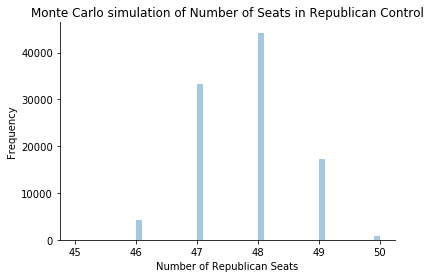

In [13]:
gop_seats = []
for i in range(100000):
    gop_seats.append(30 + stats.bernoulli.rvs(confidence.gop_win_proba, random_state= i).sum())
sns.distplot(gop_seats, kde=False)
sns.despine()
plt.xlabel('Number of Republican Seats')
plt.ylabel('Frequency')
plt.title('Monte Carlo simulation of Number of Seats in Republican Control')
plt.show()

---